In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

np.random.seed(42)

import plotly.express as px
from sklearn.model_selection import train_test_split


# Part 1 

The dataset used here is subject1's data in the second database from the Ninapro dataset (https://ninapro.hevs.ch/instructions/DB1.html). 

This dataset includes detailed information about the hand movements performed. Our objective now is to predict these movements using the EMG data by classification.

## Part 1.1. Visualize and preprocess the data for subject 2 (use only the first exercise set: S2_A1_E1 with 12 actions). 

Does the data look reasonable?

 Did you need to remove any trials?

First let's check data structure.

In [4]:
data = loadmat("s2/S2_A1_E1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


In [8]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>


In [9]:
stimulus = data['restimulus'] #indicates the type of gesture or movement being performed during each time frame of the recording
repetition = data['rerepetition'] #specifies the repetition number for the gesture being performed 
                                  #identify which instance of a gesture (e.g., first repetition, second repetition, etc.) the data corresponds to

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


VIEW RAW DATA

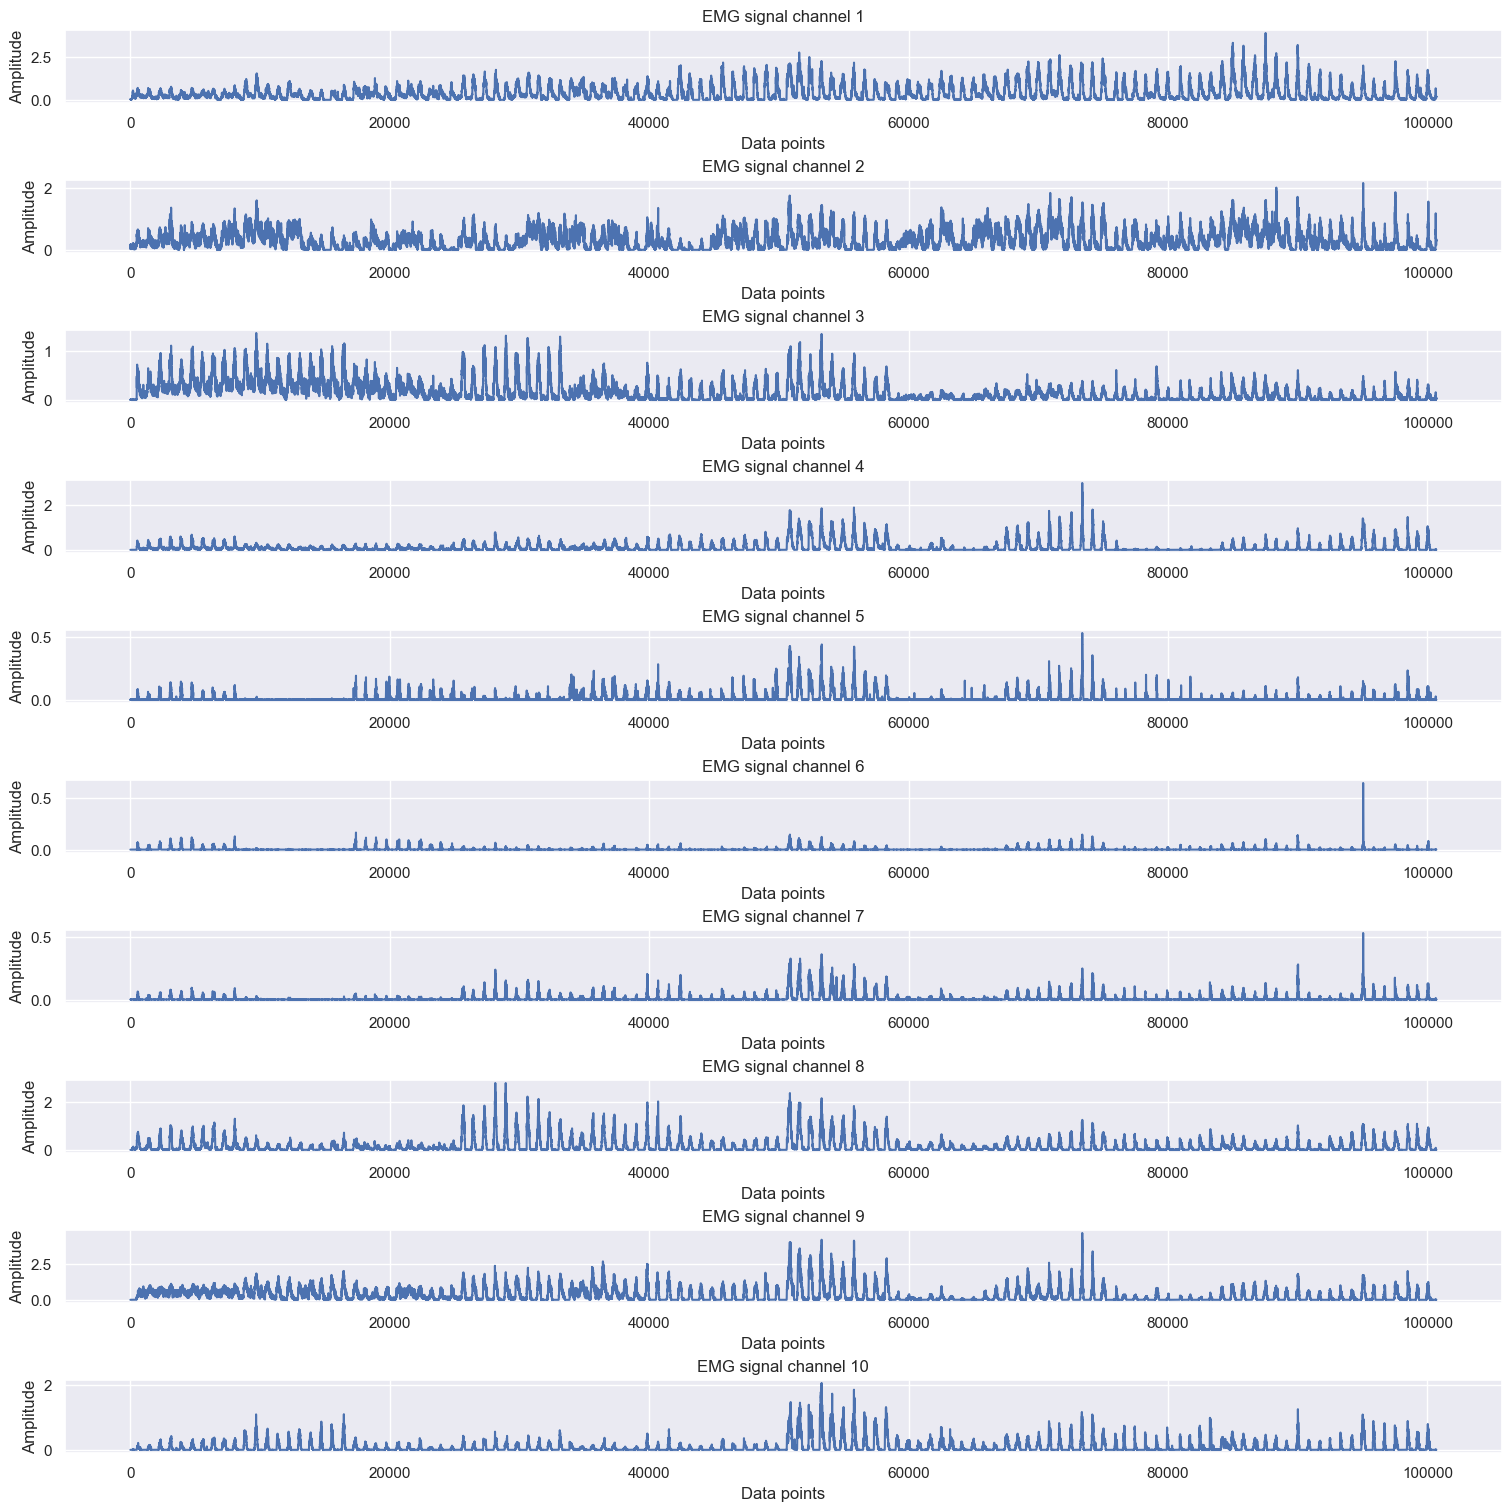

In [10]:
# Visualization of the data of the 10 channels
plt.close("all")

n_timepoints, n_channels = emg.shape

# Identify points where stimulus changes
diff = np.diff(stimulus.T).flatten()
change_points = [i + 1 for i, x in enumerate(diff) if x != 0]

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg[:, channel_idx])   
    ax[channel_idx].set_title(f"EMG signal channel {channel_idx +1}")
    ax[channel_idx].set_xlabel("Data points")
    ax[channel_idx].set_ylabel("Amplitude")
    

Pre-processing

In [11]:
emg_rectified = data["emg"].copy()
emg_rectified.shape

(100686, 10)

Next, let's look at how many samples (a.k.a timesteps) each trial (one combination of stimulation and repeats) has.

In [12]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

We can see that the number of samples for each trial is different. This is because of the nature of the task they have to perform.   

The subjects were asked to repeat movements on shown on the screen, however the time taken for each movements can differ: some could be longer than the other. 

It will not be possible to fit it into a tensor (e.g. vector is a 1-dimensional tensor) directly as the size is not the same throughout. 

Therefore, we will be using a nested list to contain and access the data in the subsequent analysis. 

### Window and envelope
Now, lets visualize the data. In this example, we will illustrate using data from a single trial (repetition 1 of stimulus 1) using moving average for detecting the envelope.

So emg_windows represent slices of the data that belong to the same repetition and stimulus so we can acess each trial!

In [13]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten() #generate a boolean mask that identifies the time points in the dataset
                                                                                                     #where both the stimulus and repetition conditions are satisfied
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :] #for all channels 
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

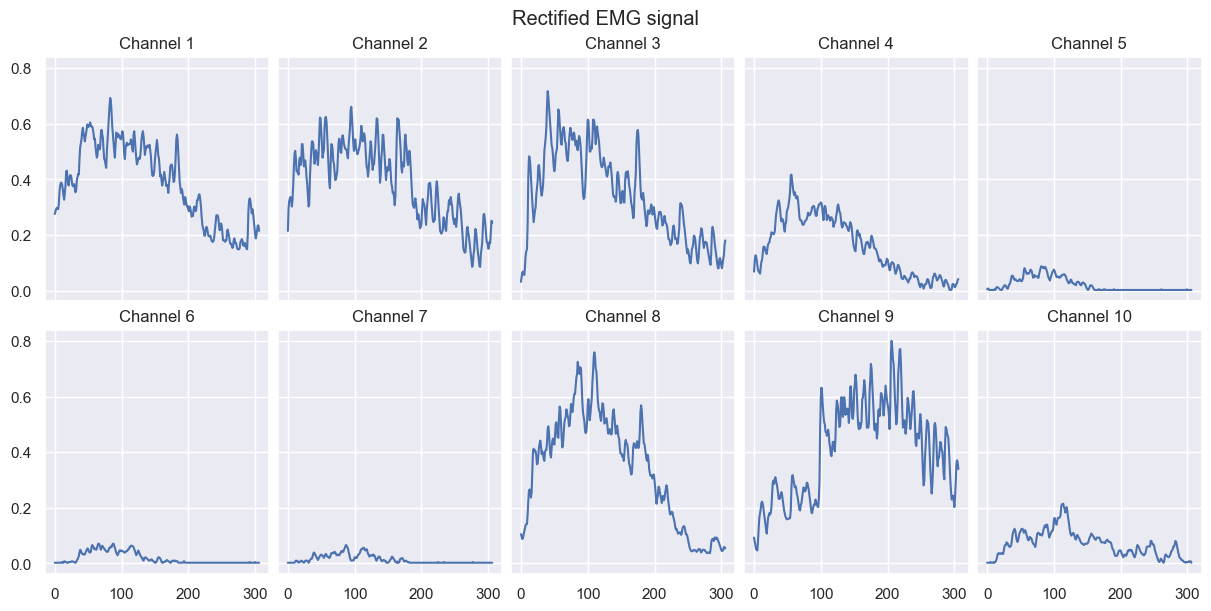

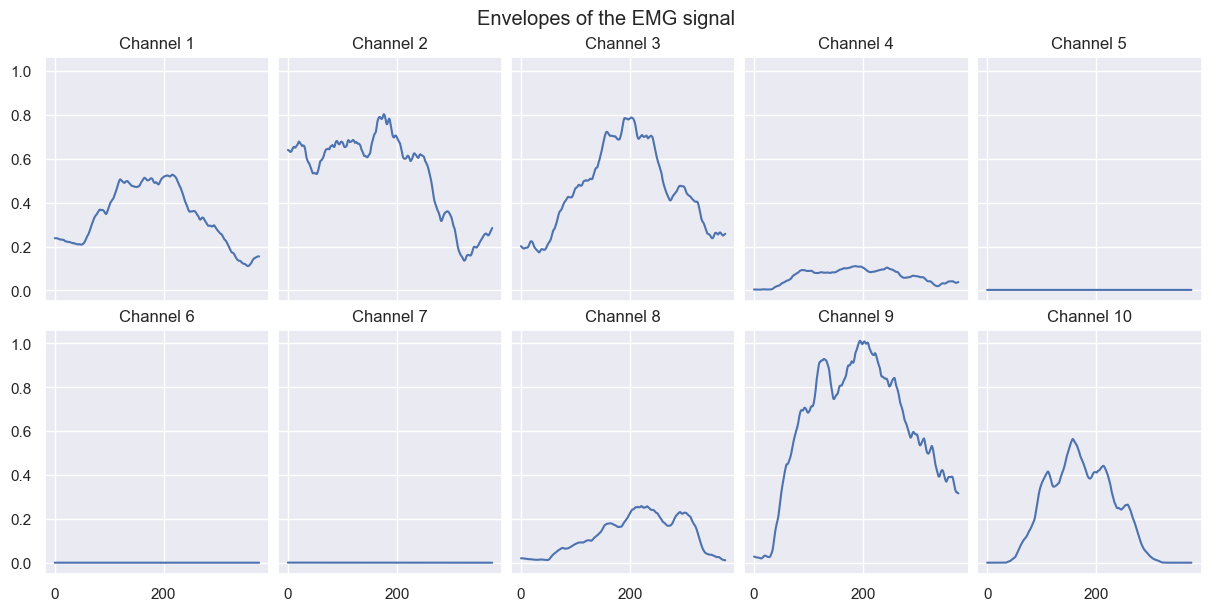

In [14]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[1][5][:, channel_idx]) #here if you change the indexes of emg_envelop you can go over the signal for a specific repetition and stimuli 
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")


### Visualizing across repetitions

Remember that we were only looking at a single trial in the previous section. 

To check for the robustness of the signal, we will generally need to repeat the stimulus multiple times and look at the trend of the signal quality over time.

In [15]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

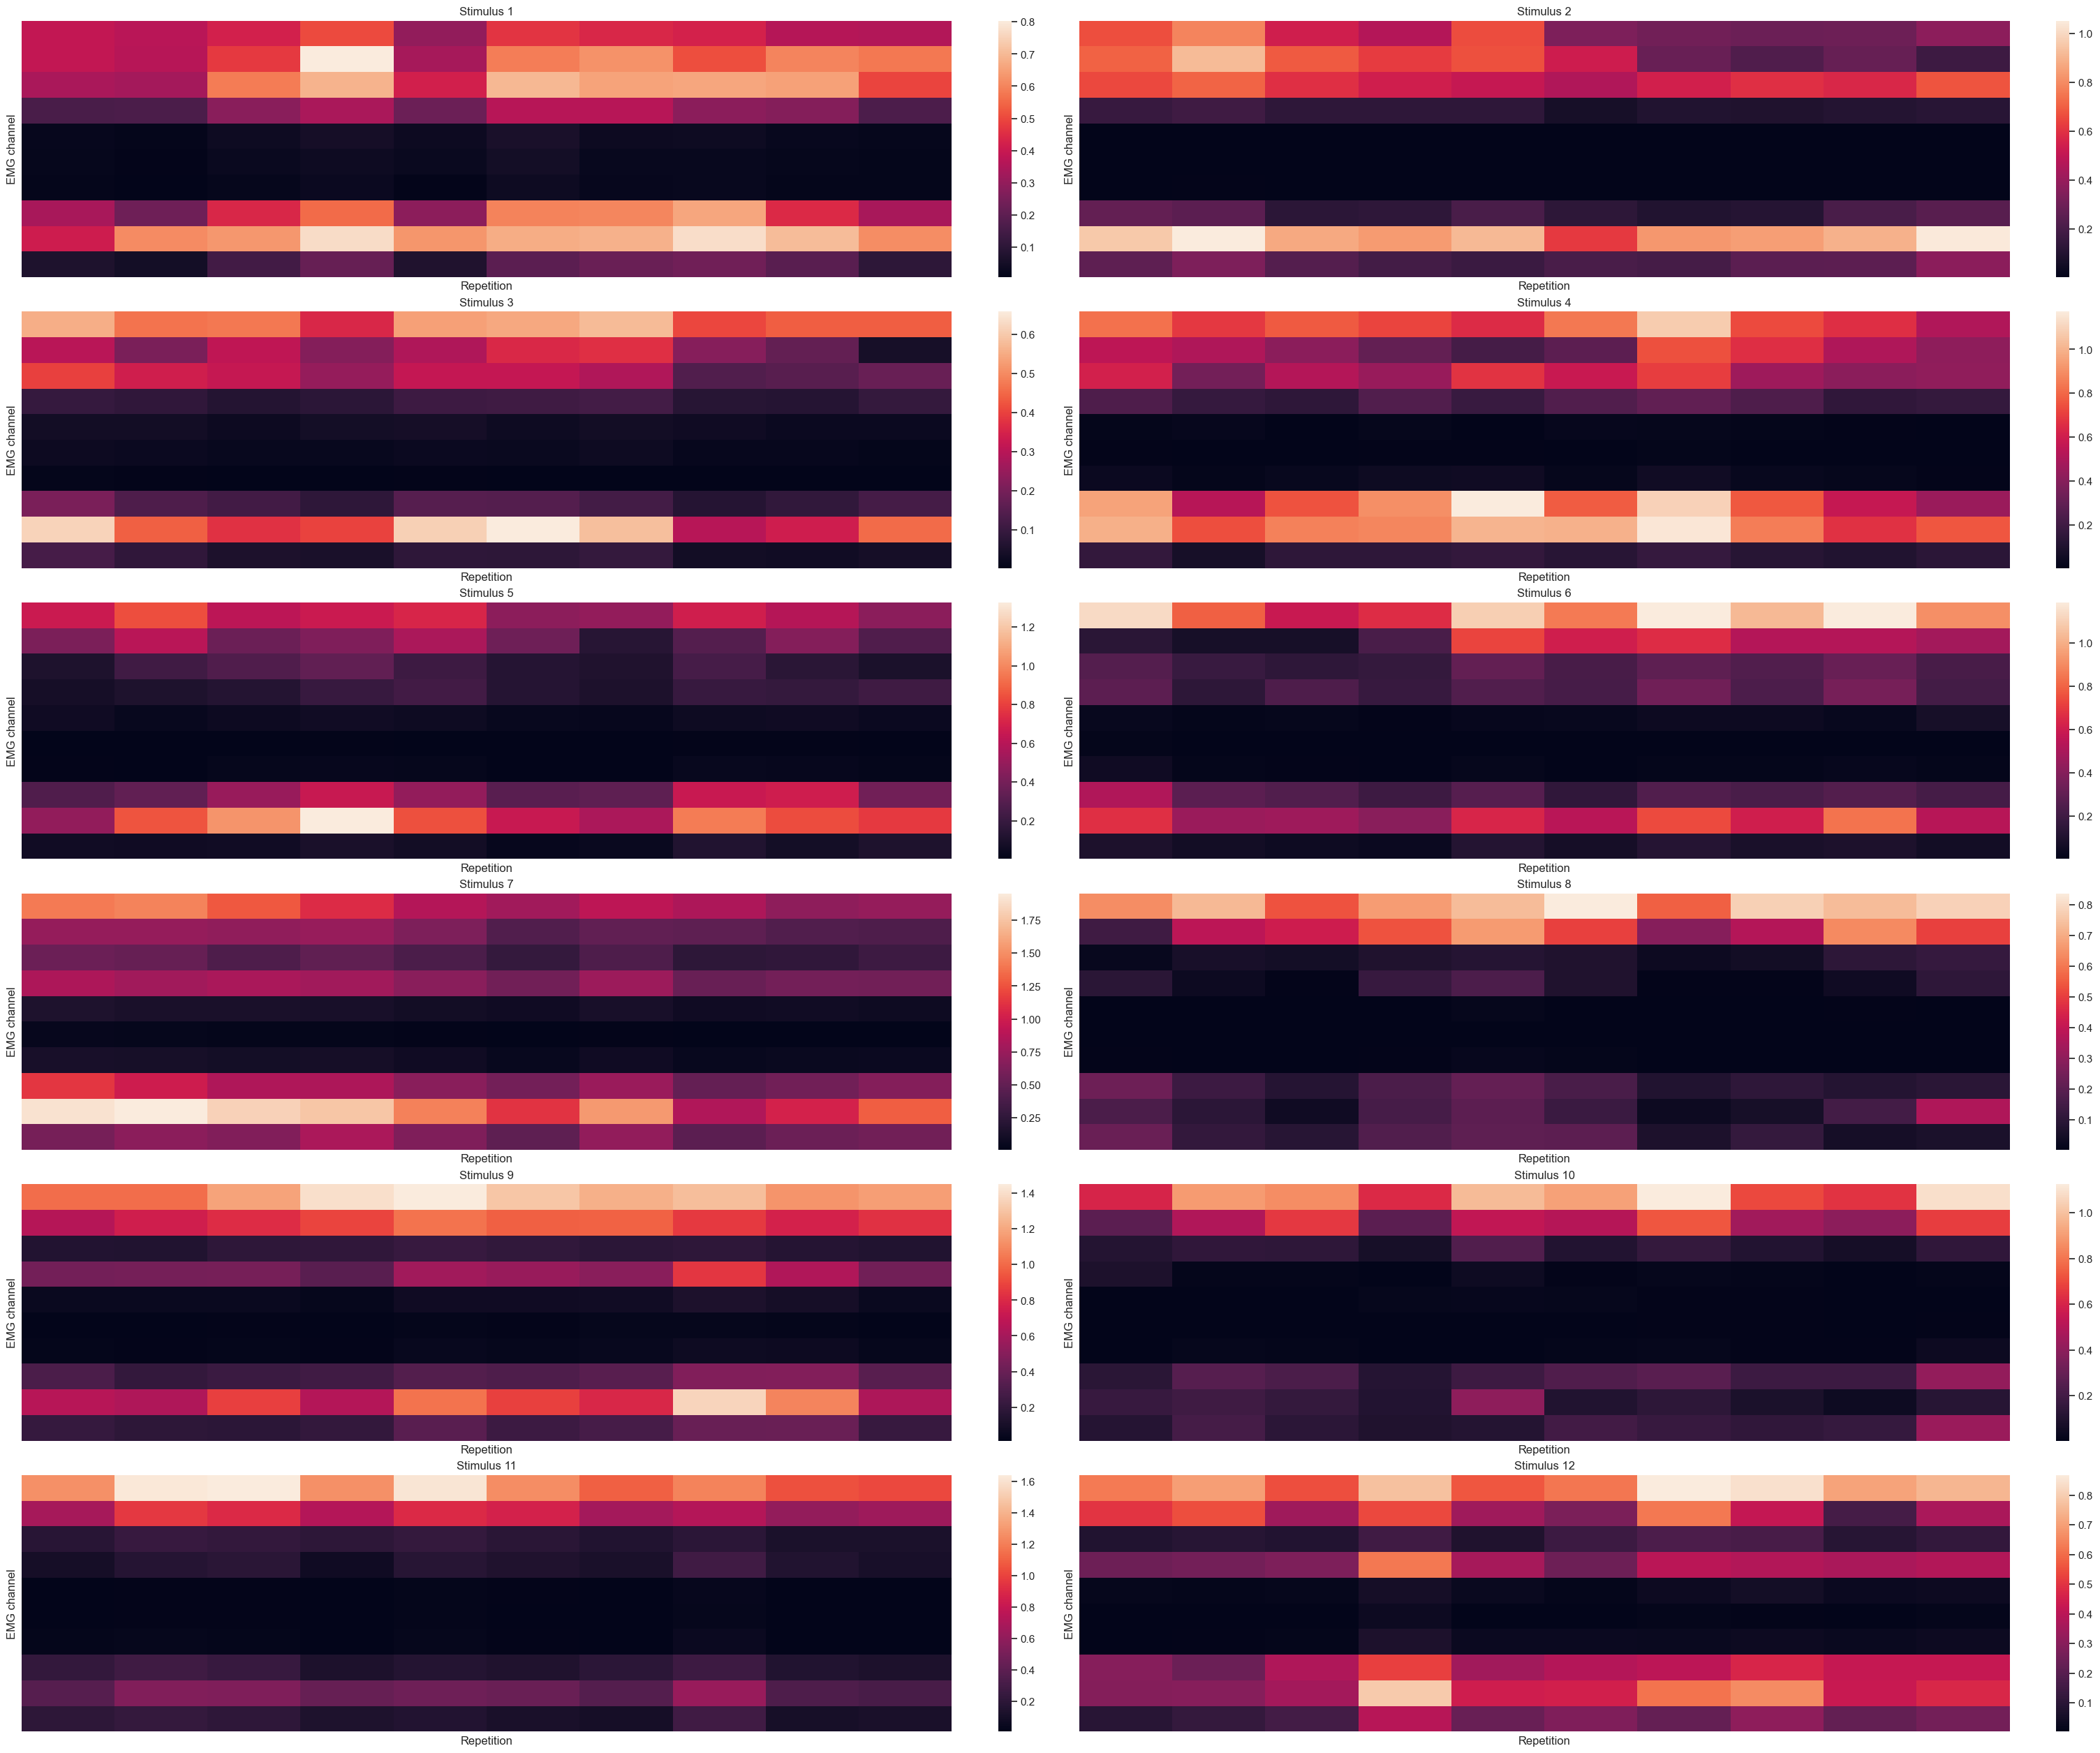

In [16]:
fig, ax = plt.subplots(6,2, figsize=(30, 25), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

Analysing this plots, we should see consistency across rows given that they represent repetitions of the same movement and the same recording location. To remove some trials, if we think needed, we should look to anomalies like abrupt changes - within each stimuli and across a specific row = same channel and != repetition.

for each stimuli, how diferent the columns are PER ROW --> because within one row for the same stimuli the signal should be similar because it is a repetition of the same thing

also we could think that low signal is bad but if it is equal for all repetitions might just be low activation!

In [17]:
#emg_average_activations has data for emg_average_activations[:, stimuli_idx, repetition_idx] 
#create a function that analysis each stimuli individually and returns repetition index of an trial where the signal is significantly diffrent from other trials 
#first approach see how differnet the mean signal is 

def trial_to_exclude(averaged_signal, stimuli_idx, threshold_factor=1.5):
    """
    Identify trials that significantly differ from others based on their mean signal.

    Parameters:
    - averaged_signal: (n_channels, n_stimuli, n_repetitions) Array of EMG signal averages.
    - stimuli_idx: Index of the stimulus to analyze (0-based).
    - threshold_factor: Factor to define significant difference (default: 2).

    Returns:
    - List of repetition indices to exclude.
    """
    # Extract the data for the current stimulus (shape: n_channels x n_repetitions)
    data_from_stimuli = averaged_signal[:, stimuli_idx, :]
    
    # Number of repetitions for this stimulus
    n_repetitions = averaged_signal.shape[2]
    
    # Compute the mean signal across all channels for each repetition
    mean_signals = np.zeros(n_repetitions)
    for repetition_idx in range(n_repetitions):
        mean_signals[repetition_idx] = np.mean(data_from_stimuli[:, repetition_idx])  # Mean across all channels

    # Compute the mean of the mean signals (overall mean across repetitions)
    overall_mean = np.mean(mean_signals)
    
    # Compute the standard deviation of the mean signals across repetitions
    std_dev = np.std(mean_signals)
    
    # Identify repetitions where the mean signal is more than `threshold_factor` times the standard deviation away from the overall mean
    deviation_from_mean = np.abs(mean_signals - overall_mean)
    
    # Mark repetitions whose deviation is greater than the threshold as anomalies
    trials_to_exclude = np.where(deviation_from_mean > threshold_factor * std_dev)[0]
    
    return trials_to_exclude

# `emg_average_activations` is an 3D array with dimensions (n_channels, n_stimuli, n_repetitions)
for stimuli_idx in range(n_stimuli):
    trials_to_exclude = trial_to_exclude(emg_average_activations, stimuli_idx)
    print(f"Trials to exclude for Stimulus {stimuli_idx + 1}: {trials_to_exclude+1}")

Trials to exclude for Stimulus 1: []
Trials to exclude for Stimulus 2: [2]
Trials to exclude for Stimulus 3: []
Trials to exclude for Stimulus 4: [7]
Trials to exclude for Stimulus 5: [4 7]
Trials to exclude for Stimulus 6: []
Trials to exclude for Stimulus 7: []
Trials to exclude for Stimulus 8: [5 7]
Trials to exclude for Stimulus 9: [8]
Trials to exclude for Stimulus 10: [10]
Trials to exclude for Stimulus 11: []
Trials to exclude for Stimulus 12: [4]


In the report we will show figures that show why this channels are removed.

## PART 1.2

Split the data into training, validation, and testing sets for the subject. Why do we need
the different datasets?

In [57]:
def prepare_trials(emg_windows, n_stimuli, n_repetitions, selected_channels):
    """
    Rearrange the data to have each trial separated with its true label and keep only specified channels.
    Parameters:
        emg_windows: 3D list or array where emg_windows[stimuli_idx][repetition_idx][channels] contains the EMG data.
        selected_channels: List of integers specifying the indices of the 10 channels to keep.
    Returns:
        trial_data: List of 2D arrays (trials) with selected channels.
        labels: List of integers (true labels corresponding to each trial).
    """
    trial_data = []  # Store the EMG data for each trial
    labels = []      # Store the corresponding labels for each trial

    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            # Extract the EMG data for the current stimulus and repetition
            trial = emg_windows[stimuli_idx][repetition_idx]
            
            # Skip if the trial has no data
            if trial is None or len(trial) == 0:
                continue
            
            # Select only the specified channels
            trial_selected_channels = trial[:, selected_channels]
            
            # Append the processed trial data and label
            trial_data.append(trial_selected_channels)
            labels.append(stimuli_idx + 1)  # Labels start from 1 for stimuli
            
    return trial_data, labels

In [58]:
data, labels = prepare_trials(emg_windows, n_stimuli, n_repetitions, selected_channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

print(f"Number of trials: {len(data)}")
print(f"Number of labels: {len(labels)}")

Number of trials: 120
Number of labels: 120


In [60]:
# Split data into training (70%) and temporary (30%) for validation and test
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42, stratify=labels
)

# Split the temporary set into validation (50% of temp) and test (50% of temp)
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Print sizes of each split
print(f"Training set: {len(train_data)} trials")
print(f"Validation set: {len(val_data)} trials")
print(f"Test set: {len(test_data)} trials")

Training set: 84 trials
Validation set: 18 trials
Test set: 18 trials


## Part 1.3 

Extract features from the trials (at least 5 different ones). Look at the typical values of
the features across the different trials. What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.

In [79]:
def mean_absolute_value(trial):
    """Mean absolute value (MAV)."""
    return np.mean(np.abs(trial), axis=0)

def root_mean_square(trial):
    """Root mean square (RMS)."""
    return np.sqrt(np.mean(trial**2, axis=0))

def waveform_length(trial):
    """Waveform length (WL)."""
    return np.sum(np.abs(np.diff(trial, axis=0)), axis=0)


def slope_sign_changes(trial, threshold=0.01):
    """Slope sign changes (SSC)."""
    diff1 = np.diff(trial, axis=0)[:-1]
    diff2 = np.diff(trial, axis=0)[1:]
    return np.sum((diff1 * diff2 < 0) & (np.abs(diff1) > threshold), axis=0)

def variance(trial):
    """Variance of the signal."""
    return np.var(trial, axis=0)

def mean_frequency(trial):
    """Mean frequency (MF)."""
    freq = np.fft.rfft(trial, axis=0)  # Perform FFT per channel
    power = np.abs(freq) ** 2
    freqs = np.fft.rfftfreq(trial.shape[0])
    return np.sum(freqs[:, None] * power, axis=0) / np.sum(power, axis=0)

def maximum_amplitude(trial):
    """Maximum amplitude (MAX)."""
    return np.max(trial, axis=0)

# Combine all feature functions
feature_functions = [
    mean_absolute_value,
    root_mean_square,
    waveform_length,
    slope_sign_changes,
    variance,
    mean_frequency,
    maximum_amplitude
]

In [80]:
def extract_features_from_trials(data):
    """
    Extract features for each channel from all trials.
    Parameters:
        data: List of 2D arrays (trials).
    Returns:
        features: 3D numpy array of shape (n_trials, n_features, n_channels).
    """
    features = []
    for trial in data:
        trial_features = []
        for func in feature_functions:
            trial_features.append(func(trial))  # Compute feature per channel
        features.append(np.array(trial_features))  # Add the trial's feature matrix
    return np.array(features)

In [92]:
train_features = extract_features_from_trials(train_data)
val_features = extract_features_from_trials(val_data)
test_features = extract_features_from_trials(test_data)

In [81]:
features = extract_features_from_trials(data)

print(f"Feature matrix shape: {features.shape}")

Feature matrix shape: (120, 7, 10)


In [89]:
from matplotlib.patches import Rectangle

def visualize_features_across_trials_with_labels(features, labels):
    """
    Visualize the feature values across trials with background colors for different labels.
    Parameters:
        features: 3D numpy array of shape (n_trials, n_features, n_channels).
        labels: List or array of labels for each trial.
    """
    n_trials, n_features, n_channels = features.shape
    feature_names = [
        "Mean Absolute Value", "Root Mean Square", "Waveform Length",
        "Slope Sign Changes", "Variance",
        "Mean Frequency", "Maximum Amplitude"
    ]

    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    # Create subplots for each feature
    fig, axes = plt.subplots(4, 2, figsize=(16, 12))
    axes = axes.flatten()

    for feature_idx in range(n_features):
        ax = axes[feature_idx]

        # Calculate the y-axis range dynamically based on data
        data_min = features[:, feature_idx, :].min()
        data_max = features[:, feature_idx, :].max()

        for trial_idx in range(n_trials):
            # Background color for the trial based on label
            label_idx = np.where(unique_labels == labels[trial_idx])[0][0]
            rect = Rectangle(
                (trial_idx - 0.5, data_min),
                width=1,
                height=data_max - data_min,
                color=colors[label_idx],
                alpha=0.3
            )
            ax.add_patch(rect)

        # Plot the feature values for each channel
        for channel_idx in range(n_channels):
            ax.plot(
                range(n_trials),
                features[:, feature_idx, channel_idx],
                label=f"Channel {channel_idx + 1}" if trial_idx == 0 else "",
                alpha=0.8
            )

        ax.set_title(feature_names[feature_idx])
        ax.set_xlabel("Trials")
        ax.set_ylabel("Feature Value")
        ax.legend(loc='upper right', fontsize=8)
        ax.set_xlim(-0.5, n_trials - 0.5)

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

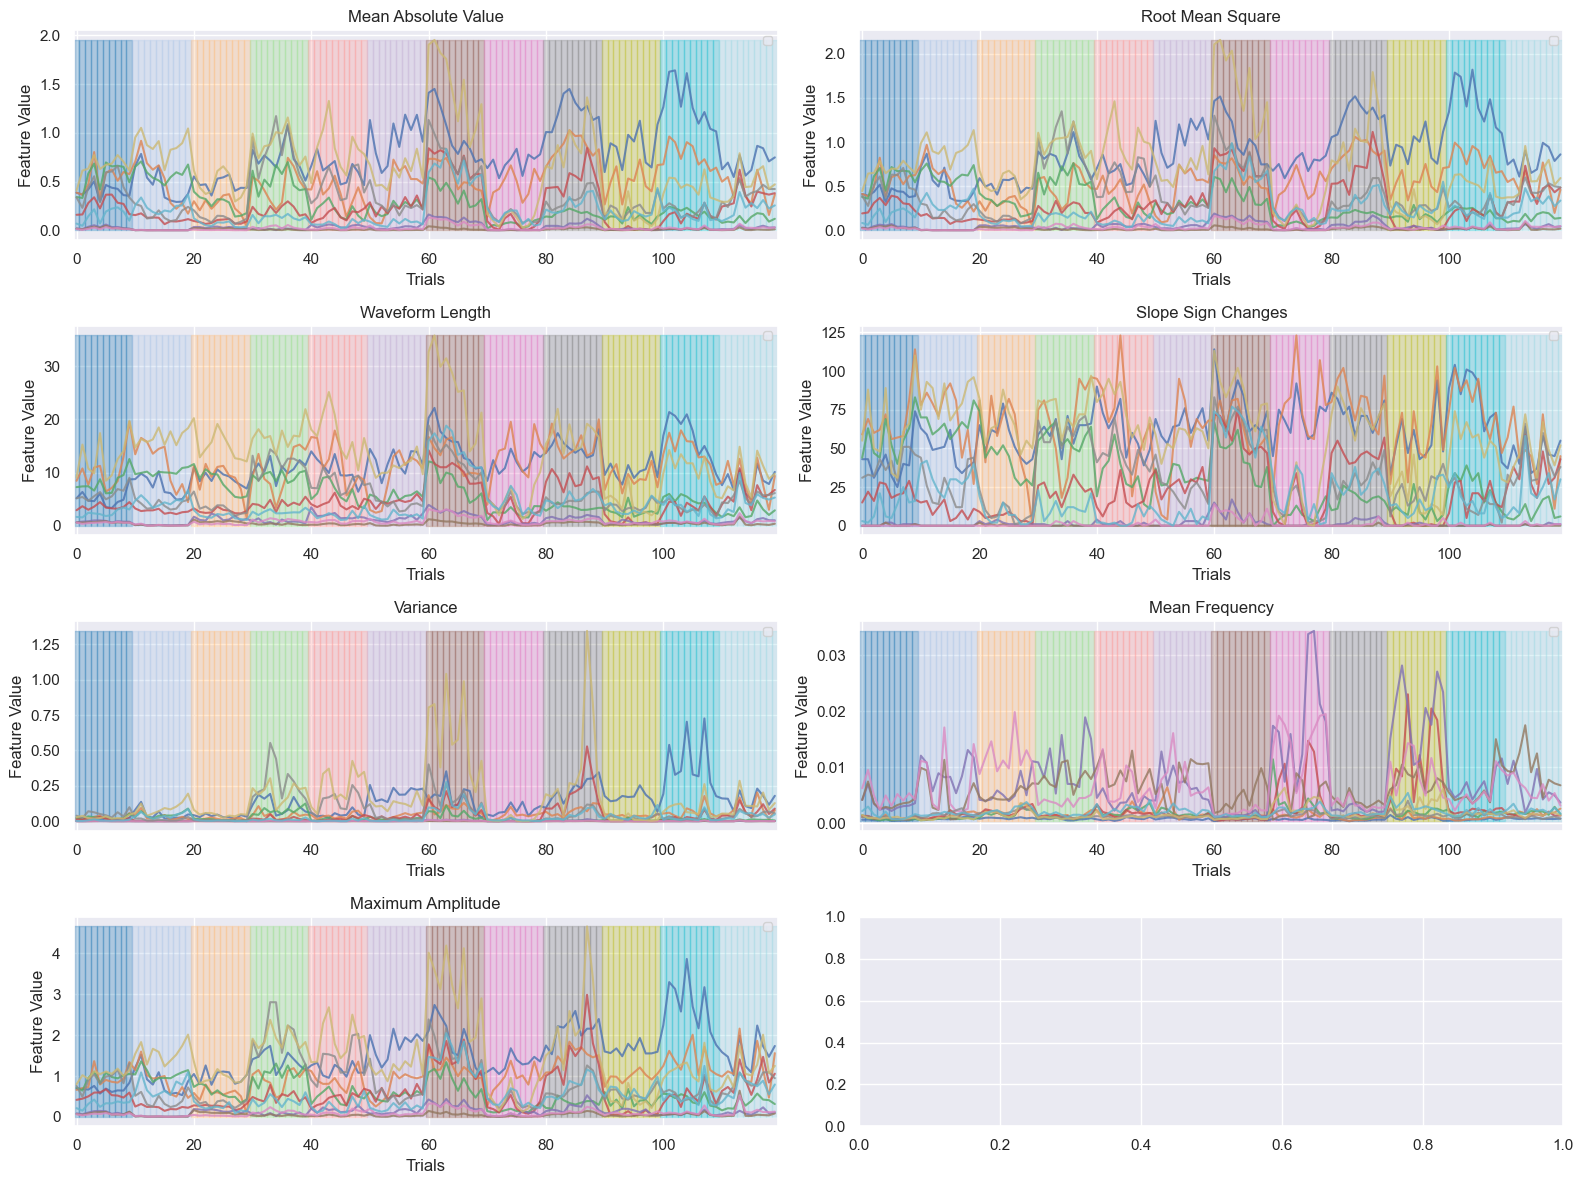

In [90]:
visualize_features_across_trials_with_labels(features, labels)

## Part 1.4

Perform classification on the data of subject 1. Predict the action of the subject based
on the EMG signals. Use hyperparameter optimization to increase your models’ performance. You will use one of the algorithm families throughout the whole project (meaning for part 1, 2 and 3) depending on your project variant:
Project Variant Algorithm Family

B : Random forest 

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Flatten the features for Random Forest
def flatten_features(features):
    """
    Flatten features from (n_trials, n_features, n_channels) to (n_trials, n_features * n_channels).
    Parameters:
        features: 3D numpy array of shape (n_trials, n_features, n_channels).
    Returns:
        Flattened 2D numpy array of shape (n_trials, n_features * n_channels).
    """
    n_trials, n_features, n_channels = features.shape
    return features.reshape(n_trials, n_features * n_channels)



# Example Random Forest classification
def perform_random_forest(features, labels):
    """
    Perform Random Forest classification on the features.
    Parameters:
        features: 3D numpy array of shape (n_trials, n_features, n_channels).
        labels: 1D array of shape (n_trials,) containing class labels.
    """
    # Flatten the features
    X = flatten_features(features)
    y = labels

    # Split into training and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize and train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest Accuracy: {accuracy:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [118]:
perform_random_forest(features, labels)

Random Forest Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       0.50      1.00      0.67         2
          12       1.00      1.00      1.00         2

    accuracy                           0.92        24
   macro avg       0.96      0.92      0.92        24
weighted avg       0.96      0.92      0.92        24

